In [1]:
from tqdm.notebook import tqdm

In [2]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table
# import astropy.units as u

# Dlnpyutils
# from dlnpyutils import utils
from dlnpyutils.utils import bspline,mad

dust_extinction
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

class Astrologium():
    '''
    A class to calculate a star's extinction, age and mass using PARSEC isochrones with 
    Gaia (E)DR3 and 2MASS photometry.
    '''
    def __init__(self,teff,abund,obsphot,distance,isochrones,ext_law='CCM89',rv=3.1):
        
        '''
        Inputs:
        ------
            teff:       2x1 array-like
                        Teff and error of star np.array([teff,teff_err])
                    
            abund:      2x1 array-like
                        first column is [M/H] and [Alpha/M] and the second column is the errors
                    
            obs_phot:   6x2 array-like
                        first column is BP, G, RP, J, H, and K and the second column is the errors
                        
            distance:   float
                        distance to star in pc
                    
            isochrones: astropy Table 
                        PARSEC isochrone table
                        
            ext_law:    string, optional
                        extinction law to use. Default is CCM89.
                        
                        Available Extinction Laws: 
                        -------------------------

                        CCM89 - Cardelli, Clayton, & Mathis 1989
                        O94 - O'Donnell 1994
                        F99 - Fitzpatrick 1999
                        F04 - Fitzpatrick 2004
                        VCG04 - Valencic, Clayton, & Gordon 2004
                        GCC09 - Grodon, Cartledge, & Clayton 2009
                        M14 - Maiz Apellaniz et al 2014
                        F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                        D22 - Decleir et al. 2022
                        
            rv:         float, optional
                        Rv (=Av/E(B-V)) extinction law slope. Default is 3.1 
                        (required to be 3.1 if ext_law = 'F99')

        '''
        
        # Teff and log(g)
        self.teff = teff[0] # temperature
        self.teff_err = teff[1] # temperature error
        
        # Salaris [Fe/H] Asplund 2021 et al.
        self.salfeh = abund[0,0]+np.log10(0.659*(10**(abund[1,0]))+0.341) # Salaris Corrected [Fe/H]
        self.salfeh_err = np.sqrt(abund[0,1]**2+((1-0.341/(0.659*(10**(abund[1,0]))+0.341))*abund[1,1])**2)
        self.phot = obsphot[:,0] # photometry
        self.phot_err = obsphot[:,1] # photometry errors
        
        # Distance modulus
        self.distance = distance
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # Absolute Magnitudes Not Derreddened
        self.absphot = self.phot-self.distmod
        
        # PARSEC isochrones
        self.labels = ['G_BPEDR3mag','GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']
        
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        self.uniq_ages = np.unique(self.iso['logAge'])
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Effective Wavelengths of different passbands in units of microns
        self.rv = rv
        self.leff = np.array([0.5387,0.6419,0.7667,1.2345,1.6393,2.1757]) #BP, G, RP, J, H, K
        self.extlaw_coeff = self.extcoeff(ext_law) # alav
        
    #################
    ### Utilities ###
    #################
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value

        Inputs:
        ------
            data:  array-like
                   data to search through

            value: float or int
                   value of interest

        Output:
        ------
            close: float or int
                   value in data closest to given value
        '''
        
        data = np.asarray(data)
        
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value

        Inputs:
        ------
            data:   array-like
                    data to search through

            value:  float or int
                    value of interest

        Output:
        ------
            close1: float or int
                    closest value under the given value

            close2: float or int
                    closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    ##################
    ### Extinction ###
    ##################
    
    def ccm_a(self,x):
        '''
        a(x) function from CCM et al. 1989

        Input:
        -----
            x: float
               effective wavelength in units of 1/micron

        Output:
        ------
            a: float
               value of the "a" function from CCM et al. 89  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a
            
    def ccm_b(self,x):
        '''
        b(x) function from ccm et al. 1989

        Input:
        -----
            x: float
               effective wavelength in units of 1/micron

        Output:
        ------
            b: float
               value of the "b" function from CCM et al. 89 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
            
    def ccm89(self,wave,rv):
        '''
        Calculate the relative extinction of one band to the V band using
        Cardelli et al. 1989 (A\lambda/Av)

        Inputs:
        ------
            wave: float
                  effective wavelength in units of micron

            rv:   float
                  Rv Slope of the extinction law (= Av/E(B-V))

        Output:
        ------
            alav: float
                  extinction relative to Av (A\lambda/Av)
        '''
        x=1/wave
        
        ### check if just a float and return float 
        if np.size(x)<=1:
            return self.ccm_a(x)+self.ccm_b(x)/rv
    
        ### if not float calculate the extinction for the whole array like object
        alav = 999999.0*np.ones(len(x))
        for i in range(len(x)):
            alav[i] = self.ccm_a(x[i])+self.ccm_b(x[i])/rv
        
        return alav
    
    def f99(self,wave):
        '''
        Calculate the relative extinction to E(B-V) using Fitzpatrick 1999 extinction law
        assuming Rv (= Av/E(B-V)) is the standard 3.1 for the Milky Way
        
        Input:
        -----
            wave: float
                  effective wavelength in units of microns
        
        Output:
        ------
            alav: float
                  extinction relative to Av (A\lambda/Av)
        '''
        recip_anchors = np.array([0.000,0.377,0.820,1.667,1.828,2.141,2.433,3.704,3.846])
        alebv_anchors = np.array([0.000,0.265,0.829,2.688,3.055,3.806,4.315,6.265,6.591])
        
        x=1/wave
        spl = interp1d(recip_anchors,alebv_anchors)
        alav = spl(x)/3.1
        return alav
    
#     def extinction_coeff(self,law):
#         '''
#         Calculate the extincion law coefficients for the BP, G, RP, J, H, and K bands
        
#         Input:
#         -----
#             law:             string
#                              extinction law to use
                             
#             rv:              float
#                              Rv (=Av/E(B-V)) extinction law slope. Default is 3.1.
#                              (required to be 3.1 if ext_law = 'F99')
                 
#         Output:
#         ------
#             ext_coeff_array: array
#                              calculated extinction coefficients for the BP, G, RP, J, H, and K bands 
#                              relative to the Gaia G band
#         '''
#         if law == 'CCM89':
#             ext_coeff_array = self.ccm89(self.leff,self.rv)
            
#         elif law == 'F99':
#             ext_coeff_array = self.f99(self.leff)
            
#         return ext_coeff_array
    
    def extcoeff(self,wavelength,rv=3.1,law='CCM89'):#,ref='G'):

        '''
        Calculate the relative extincion law coefficients for a given wavelength relative to the 
        BP, G, RP, J, H, K or user defined band

        Input:
        -----
            wavelength: float
                        Effective wavelength of band of interest in microns

            law:        str
                        extinction law to use

                        Available Extinction Laws: 
                        -------------------------

                        CCM89 - Cardelli, Clayton, & Mathis 1989
                        O94 - O'Donnell 1994
                        F99 - Fitzpatrick 1999
                        F04 - Fitzpatrick 2004
                        VCG04 - Valencic, Clayton, & Gordon 2004
                        GCC09 - Grodon, Cartledge, & Clayton 2009
                        M14 - Maiz Apellaniz et al 2014
                        F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                        D22 - Decleir et al. 2022

            rv:         float
                        Rv (=Av/E(B-V)) extinction law slope. Default is 3.1

            #ref:        str or float
            #            reference filter. Can be 'BP', 'G', 'RP', 'J', 'H', 'K' 
            #            or user defined float that is the wavelength in microns of the band

        Output:
        ------
            ext_coeff:  float
                        calculated extinction coefficients for the BP, G, RP, J, H, and K bands 
                        relative to the Gaia G band

        '''

        leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}

        # select the extinction model
        if law == 'CCM89':
            ext_model = CCM89(Rv=rv)

        elif law == 'O94':
            ext_model = O94(Rv=rv)

        elif law == 'F99':
            ext_model = F99(Rv=rv)

        elif law == 'F04':
            ext_model = F04(Rv=rv)

        elif law == 'VCG04':
            ext_model = VCG04(Rv=rv)

        elif law == 'GCC09':
            ext_model = GCC09(Rv=rv)

        elif law == 'M14':
            ext_model = M14(Rv=rv)

        elif law == 'F19':
            ext_model = F19(Rv=rv)

        elif law == 'D22':
            ext_model = D22(Rv=rv)   

        # Calculate the relative extinction coefficient
#         if type(ref) == str:
#             ext_coeff = ext_model(wavelength*u.micron)#/ext_model(leff[ref]*u.micron)

#         elif type(ref) == float:
#         ext_coeff = ext_model(wavelength*u.micron)#/ext_model(ref*u.micron)
        ext_coeff_array = ext_model(np.reciprocal(self.leff*u.micron))

        return ext_coeff_array
    
    def extinction(self):
        '''
        Calulate the extinctions for the BP, G, RP, J, H, and K bands
        
        Output:
        ------
            ext: 6x2 array
                 first column is the extinction values and the second is the errors
            
        '''
        
        # isochrone magnitude labels
        color_labels = np.array([['G_BPEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag'],
                                 ['GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']]).T
        
        # pick isochrone points with temperatures within 200 K of the star's Teff
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+200.))&
                           (self.iso['logTe']>np.log10(self.teff-200.)))
        iso_ = self.iso[teffcut]
        
        # check to make sure teff of star is in range of the isochrone
        if np.size(np.squeeze(teffcut))==0:
            self.ext = 999999.0*np.ones((6,2))
            return 999999.0*np.ones((6,2))
    
        # get colors and errors
        obs_colors = np.delete(self.phot-self.phot[1],1)
        obs_colors[1:] = -1*obs_colors[1:]
        obs_colors_err = np.delete(np.sqrt(self.phot_err**2+self.phot_err[1]**2),1)
        
        # create "reddening" vector (slightly modified from the normal definition)
        
        red_vec = np.delete(1-self.extlaw_coeff/self.extlaw_coeff[1],1)
        red_vec[0] = -1*red_vec[0]
        
        ext_vec = self.extlaw_coeff/self.extlaw_coeff[1]
        
#         red_vec = np.array([self.extlaw_coeff[0]-1.0,1.0-self.extlaw_coeff[1],1.0-self.extlaw_coeff[2],
#                             1.0-self.extlaw_coeff[3],1.0-self.extlaw_coeff[4],1.0-self.extlaw_coeff[5]])
#         ext_vec = self.extlaw_coeff
        
        # calculate the intrinsic colors using a b-spline
        bspline_vec = 999999.0*np.ones(5)
        bspline_vec_deriv = 999999.0*np.ones(5)
        
        for i in range(5):
            try:
                # Interpolate the color-Teff relation using a b-spline
                color = (iso_[color_labels[i,0]]-iso_[color_labels[i,1]])
                logTe = iso_['logTe']

                bspl = bspline(logTe,color)
                bspline_vec[i] = bspl(np.log10(self.teff))
                bspline_vec_deriv[i] = bspl.derivative()(np.log10(self.teff))
                
            except:
                bspline_vec[i] = 999999.0
                bspline_vec_deriv[i] = 999999.0
                
        # calculate the extinctions and errors
        color_diff = obs_colors-bspline_vec
#         color_diff_err = obs_colors_err
        color_diff_err = np.sqrt(obs_colors_err**2+
                                 (np.multiply(bspline_vec,
                                              np.divide(bspline_vec_deriv*self.teff_err,self.teff)))**2)
#         color_diff_err = np.multiply(color_diff,np.sqrt(np.divide(obs_colors_err,obs_colors)**2+
#                                      np.divide(bspline_vec_deriv*self.teff_err,self.teff)**2))
        
#         print('red_vec',red_vec)
#         print('ext_vec',ext_vec)
#         print('color_diff',color_diff)
        
        # find bad values this should take care of bad values from the spline
        neg_cut = np.where(color_diff>0)
#         print(np.dot(red_vec[neg_cut],color_diff[neg_cut]))
#         print('#####')
        
        # if all bad return bad values
        if np.size(np.squeeze(neg_cut))==0:
            self.ext = 999999.0*np.ones((6,2))
            return 999999.0*np.ones((6,2))
        
        # calculate the extinction value and error
        ag = np.dot(red_vec[neg_cut],color_diff[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
#         ag_err = np.dot(red_vec[neg_cut],obs_colors_err[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        ag_err = np.dot(red_vec[neg_cut],color_diff_err[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        
        
        ext = 999999.0*np.ones((6,2))
        ext[:,0] = ext_vec*ag
        ext[:,1] = ext_vec*ag_err
        
        self.ext = ext
        
        return ext
    
    #############################################
    ### Gonz\'{a}lez Hern\'{a}dez & Bonifacio ###
    #############################################
    
    def ghb_jk_teff(self,jk):
        '''
        Calculate the photometric Teff of a star using Gonz\'{a}lez Hern\'{a}dez & Bonifacio 2009
        
        Input:
        -----
            jk:   float
                  J - K color
                
        Output:
        ------
            teff: float
                  photometric teff
        '''
        b = np.array([0.6517,0.6312,0.0168,-0.0381,0.0256,0.0013])
        
        theta_eff = b[0]+b[1]*jk+b[2]*(jk**2)+b[3]*(jk*self.salfeh)+b[4]*self.salfeh+b[5]*(self.salfeh**2)
        teff = 5040/theta_eff
        self.ghb_teff = teff
        return teff
    
    ##############################################
    ### Magnitudes, Extinctions, Ages & Masses ###
    ##############################################
    
    def teff_2_appmags(self,teff,age,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff:     float
                      Teff of star 
                      
            age:      float
                      age of star
        
        Output:
        ------
            calc_mag: 6x2 array 
                      expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        extincts = self.ext[:,0]
        
        lgage = np.log10(age*10**9)
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(6)
            for i in range(6):
                mag_spl = bspline(iso_['logTe'],iso_[self.labels[i]])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
                
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### use a b-spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(6)
            for i in range(6):
                mag_spl_lo = bspline(iso_lo['logTe'],iso_lo[self.labels[i]]) 
                mag_spl_hi = bspline(iso_hi['logTe'],iso_hi[self.labels[i]])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
                
            lgg_spl_lo = bspline(iso_lo['logTe'],iso_lo['logg'])
            lgg_spl_hi = bspline(iso_hi['logTe'],iso_hi['logg'])

            return calc_mags
    
    def get_age(self,guess_ages=np.linspace(0.,17.)[::10],verbose=False):
        '''
        Find best fitting age for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_ages: array 
                        initial guesses for ages in Gyr

            
        Output:
        ------
            age:        float 
                        best age according to chi^2 space search
                        
            chi:        float
                        best chi^2 according to chi^2 space search
                        
            rms:        float
                        RMSE of the result
            
        '''
            
        # initialize lists
        
        curve_ages = []
        curve_chi = []
        curve_rms = []

        # loop over age and ak space 
        for j in range(len(guess_ages)): 
            try:
                # calculate best fit parameters and covariance matrix
                popt,pcov = curve_fit(self.teff_2_appmags,self.teff,self.phot,p0=guess_ages[j],
                                      method='lm',sigma=self.phot_err,
                                      absolute_sigma=True,maxfev=5000)

                # populate lists
                curve_ages.append(popt[0])
                curve_mags = np.asarray(self.teff_2_appmags(self.teff,popt[0]))

                curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))
                curve_rms.append(np.sqrt(sum((curve_mags-self.phot)**2)/len(curve_mags)))

            except:
                # populate lists
                curve_ages.append(999999.0)
                curve_chi.append(999999.0)
                curve_rms.append(999999.0)
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        age = np.asarray(curve_ages)[idx]
        chi = np.asarray(curve_chi)[idx]
        rms = np.asarray(curve_rms)[idx]
        self.age = age
        self.chi = chi
        self.rms = rms

        return age, chi, rms
    
    ##############
    ### Masses ###
    ##############
    
    def age_2_mass(self,age):
        '''
        Calculate the mass of a star from its age
        
        Input:
        -----
            age:      2x1 array
                      age of a star in Gyr and associated error

        Output:
        ------
            mass:     float 
                      mass of star in solar masses
            
            mass_err: float
                      error in the calculated mass of the star
        '''

        if self.age == 999999.0:
            return 999999.0
#             return np.array([999999.0,999999.0])
        
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+200.))&
                           (self.iso['logTe']>np.log10(self.teff-200.)))
        iso_ = self.iso[teffcut]
        
        if np.size(iso_) < 2:
            return 999999.0
#             return np.array([999999.0,999999.0])
        
        ### calculate the mass and error using interpolation
        bspl = bspline(iso_['logAge'],iso_['Mass'])
        mass = bspl(np.log10(age*10**9))
        
        if np.isfinite(mass)==False:
            return 999999.0
        
        return mass
    
#         mass = bspl(np.log10(age[0]*10**9))
#         mass_deriv = bspl.derivative()(np.log10(age[0]*10**9))
#         mass_err = np.abs(mass_deriv)*age[1]
        
#         self.mass = np.array([mass,mass_err])
        
#         return mass#, mass_err
        
    def mass_2_age(self,mass):
        '''
        Calculate the age of a star given a mass using PARSEC isochrones

        Input:
        -----
            mass: float
                  mass of star in solar masses

        Output:
        ------
            age:  float
                  age of star in Gyr
        '''
        
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+200.))&
                           (self.iso['logTe']>np.log10(self.teff-200.)))
        iso_ = self.iso[teffcut]
        
        spl = bspline(iso_['Mass'],iso_['logAge'])
        age = 10**spl(mass)/10**9
        return age
        
# #         try:
#         mass_lo,mass_hi = self.neighbors(self.iso['Mass'],mass)

#         iso_lo = self.iso[np.where(self.iso['Mass']==mass_lo)]
#         iso_hi = self.iso[np.where(self.iso['Mass']==mass_hi)]

#         # younger
#         spl_lo = bspline(iso_lo['Mass'],10**iso_lo['logAge']/10**9)

#         # older
#         spl_hi = bspline(iso_hi['Mass'],10**iso_hi['logAge']/10**9)

#         # final spline
#         final_spl = interp1d([mass_lo,mass_hi],[spl_lo(self.salfeh),spl_hi(self.salfeh)])
#         age = final_spl(mass)
#         return age
    
    def iterative_age_mass(self,initial_age,initial_mass,max_iter=10,dage=0.1,dmass=0.01):
        '''
        Iteratively calculate the age and mass using previously calculated values
        
        Inputs:
        ------
            initial_age:  float
                          initial age to start calculation
            
            initial_mass: float
                          initial mass to start calculation
                          
            max_iter:     float
                          maximum number of iterations
                          
            dage:         float
                          adjacent age difference threshold
                          
            dmass:        float
                          adjacent mass difference threshold
                          
        Output:
        ------
            new_age:      float
                          final age of star
                          
            new_mass:     float
                          final mass of star
        '''
        
        
        ### Initialize
        i = 0
        
        old_age = initial_age
        old_mass = initial_mass
        new_age = 0
        new_mass = 0
        
        new_age = self.mass_2_age(old_mass)
        new_mass = self.age_2_mass(new_age)
        
        new_age_2 = self.mass_2_age(new_mass)
        new_mass_2 = self.age_2_mass(new_age_2)
        
#         while (np.abs(new_age - old_age) > dage) & (np.abs(new_mass - old_mass) > dmass):
            
#             if i > max_iter:
#                 break
            
#             old_age = new_age
#             old_mass = new_mass
                
#             new_age = self.mass_2_age(old_mass)
#             new_mass = self.age_2_mass(new_age)
            
#             i += 1
            
        return new_age, new_mass, new_age_2, new_mass_2
    
    def iterative_age_mass2(self,initial_age,initial_mass,max_iter=10,dage=0.1,dmass=0.01):
        '''
        Iteratively calculate the age and mass using previously calculated values
        
        Inputs:
        ------
            initial_age:  float
                          initial age to start calculation
            
            initial_mass: float
                          initial mass to start calculation
                          
            max_iter:     float
                          maximum number of iterations
                          
            dage:         float
                          adjacent age difference threshold
                          
            dmass:        float
                          adjacent mass difference threshold
                          
        Output:
        ------
            new_age:      float
                          final age of star
                          
            new_mass:     float
                          final mass of star
        '''
        
        i = 0
        
#         print(initial_age)
#         print(initial_mass)
        
        old_age = initial_age
        old_mass = initial_mass
        new_age = 0
        new_mass = 0
        
        if (np.abs(new_age-old_age) < 0.5) | (np.abs(new_mass-old_mass) < 0.5):
            print(r'small')
        else:
            print(r'large')
            
#         return None
            
        

In [3]:
leff = np.array([0.5387,0.6419,0.7667,1.2345,1.6393,2.1757])

def ccm_a(x):
    '''
    a(x) function from CCM et al. 1989

    Input:
    -----
        x: float
           effective wavelength in units of 1/micron

    Output:
    ------
        a: float
           value of the "a" function from CCM et al. 89  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a

    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
             0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a

    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a

        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a

def ccm_b(x):
    '''
    b(x) function from ccm et al. 1989

    Input:
    -----
        x: float
           effective wavelength in units of 1/micron

    Output:
    ------
        b: float
           value of the "b" function from CCM et al. 89 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b

    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
             0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b

    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b

        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b

def ccm89(wave,rv=3.1):
    '''
    Calculate the relative extinction of one band to the V band using
    Cardelli et al. 1989 (A\lambda/Av)

    Inputs:
    ------
        wave: array like
              effective wavelength in units of micron

        rv:   float
              Rv Slope of the extinction law (= Av/E(B-V)). default is 3.1

    Output:
    ------
        alav: float
              extinction relative to Av (A\lambda/Av)
    '''
    x=1/wave
    
    if np.size(x)<=1:
        return ccm_a(x)+ccm_b(x)/rv
    
    alav = 999999.0*np.ones(len(x))
    for i in range(len(x)):
        alav[i] = ccm_a(x[i])+ccm_b(x[i])/rv
        
    return alav

from scipy.interpolate import interp1d

def f99(wave):
    '''
    Calculate the relative extinction to E(B-V) using Fitzpatrick 1999 extinction law
    assuming Rv (= Av/E(B-V)) is the standard 3.1 for the Milky Way

    Input:
    -----
        wave: float
              effective wavelength in units of microns

    Output:
    ------
        alav: float
              extinction relative to Av (A\lambda/Av)
    '''
    recip_anchors = np.array([0.000,0.377,0.820,1.667,1.828,2.141,2.433,3.704,3.846])
    alebv_anchors = np.array([0.000,0.265,0.829,2.688,3.055,3.806,4.315,6.265,6.591])

    x=1/wave
    spl = interp1d(recip_anchors,alebv_anchors)
    alav = spl(x)/3.1
    return alav

def sfdebv_2_ext(ebv,wave):
    '''
    Convert Schlegel Reddening to extinction using Schlafly et al. 2010 and Fitzpatrick 1999
    
    Inputs:
    ------
        ebv:  float
              Schlegel E(B-V) value
              
        wave: float
              wavelength of band to calculate extinction in mircons
        
    Output:
    ------
        ext:  float
              extinction in the band with the effective wavelength of wave
    '''
    
    micron_ext = (0.78/1.32)*ebv # Schlafly et al. 2010
    ext = f99(wave)/f99(1)*micron_ext # Fitzpatrick 1999
    return ext

import astropy.units as u
def convert_sfdebv(wave,ebv,rv=3.1):
    '''
    Convert Schlegel Reddening to extinction using Schlafly et al. 2010
    
    Inputs:
    ------
        wave: wavelength of band to calculate extinction in mircons
        ebv: Schlegel E(B-V) value
        
    Output:
    ------
        new_extinction: extinction in the band with the effective wavelength of wave
    '''
    
    micron_extinction = (0.78/1.32)*ebv
    fitz = F99(Rv=rv)
    return fitz(1/(wave*u.micron))/fitz(1*u.micron)*micron_extinction

import astropy.units as u
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

def extcoeff(wavelength,rv=3.1,law='CCM89',ref='G'):

    '''
    Calculate the relative extincion law coefficients for a given wavelength relative to the 
    BP, G, RP, J, H, K or user defined band

    Input:
    -----
        wavelength: float
                    Effective wavelength of band of interest in microns
        
        law:        str
                    extinction law to use
                         
                    Available Extinction Laws: 
                    -------------------------
                        
                    CCM89 - Cardelli, Clayton, & Mathis 1989
                    O94 - O'Donnell 1994
                    F99 - Fitzpatrick 1999
                    F04 - Fitzpatrick 2004
                    VCG04 - Valencic, Clayton, & Gordon 2004
                    GCC09 - Grodon, Cartledge, & Clayton 2009
                    M14 - Maiz Apellaniz et al 2014
                    F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                    D22 - Decleir et al. 2022

        rv:         float
                    Rv (=Av/E(B-V)) extinction law slope. Default is 3.1
        
        ref:        str or float
                    reference filter. Can be 'BP', 'G', 'RP', 'J', 'H', 'K' 
                    or user defined float that is the wavelength in microns of the band

    Output:
    ------
        ext_coeff:  float
                    calculated extinction coefficients for the BP, G, RP, J, H, and K bands 
                    relative to the Gaia G band

    '''

    leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
    
    # select the extinction model
    if law == 'CCM89':
        ext_model = CCM89(Rv=rv)

    elif law == 'O94':
        ext_model = O94(Rv=rv)

    elif law == 'F99':
        ext_model = F99(Rv=rv)

    elif law == 'F04':
        ext_model = F04(Rv=rv)

    elif law == 'VCG04':
        ext_model = VCG04(Rv=rv)

    elif law == 'GCC09':
        ext_model = GCC09(Rv=rv)

    elif law == 'M14':
        ext_model = M14(Rv=rv)

    elif law == 'F19':
        ext_model = F19(Rv=rv)

    elif law == 'D22':
        ext_model = D22(Rv=rv)   

    # Calculate the relative extinction coefficient
    if type(ref) == str:
        ext_coeff = ext_model(wavelength*u.micron)/ext_model(leff[ref]*u.micron)
    
    elif type(ref) == float:
        ext_coeff = ext_model(wavelength*u.micron)/ext_model(ref*u.micron)
    
    return ext_coeff

In [4]:
f99(np.array([0.5387,0.6419,0.7667,1.2345,1.6393,2.1757]))

array([1.00740379, 0.78983613, 0.61029828, 0.26333076, 0.18118131,
       0.11941594])

In [5]:
ccm89(leff)/ccm89(leff)[1]

array([1.21824778, 1.        , 0.76998356, 0.34261803, 0.21702551,
       0.13758671])

In [6]:
extcoeff(leff)

array([1.21821835, 1.        , 0.77005965, 0.34260963, 0.21702019,
       0.13758333])

In [7]:
red_vec = np.array([ccm89(leff[0])/ccm89(leff[1])-1.,
                   1.-ccm89(leff[2])/ccm89(leff[1]),
                   1.-ccm89(leff[3])/ccm89(leff[1]),
                   1.-ccm89(leff[4])/ccm89(leff[1]),
                   1.-ccm89(leff[5])/ccm89(leff[1])])
            
ext_vec = np.array([ccm89(leff[0])/ccm89(leff[1]),1.,
                   ccm89(leff[2])/ccm89(leff[1]),
                   ccm89(leff[3])/ccm89(leff[1]),
                   ccm89(leff[4])/ccm89(leff[1]),
                   ccm89(leff[5])/ccm89(leff[1])])

print(red_vec)
print(ext_vec)

[0.21824778 0.23001644 0.65738197 0.78297449 0.86241329]
[1.21824778 1.         0.76998356 0.34261803 0.21702551 0.13758671]


# PARSEC

In [8]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec36_DR2_EDR3.fits')
massive = Table(massive[np.where(massive['label']==3.0)])
# massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['MH','Mass','logAge','logTe','logg','GEDR3mag','G_BPEDR3mag','G_RPEDR3mag',
                  'Jmag','Hmag','Ksmag']

# APOKASC 

<ipython-input-9-33ec0aef37b5>:4: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)


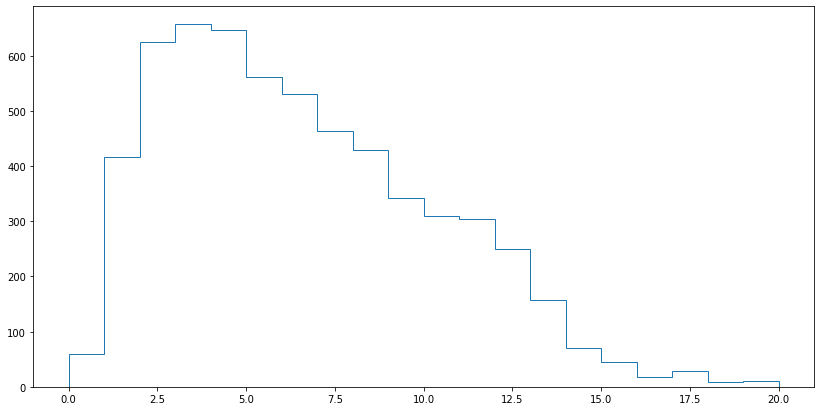

In [9]:
# dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec.fits.gz')
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec_rev1.fits.gz')
apoafe = dr17['ALPHA_M']+dr17['M_H']-dr17['FE_H']
apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)

# 0.659, 0.341 from Asplund et al 2021.
salfeh = dr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(dr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe_err))+0.341))*apoafe)**2)

k674 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.4.fits.gz')

# xmatch APOKASC with DR17
_, k674idx, dr17idx = np.intersect1d(k674['2MASS_ID'],dr17['APOGEE_ID'],return_indices=True)

k674 = k674[k674idx]
kdr17 = dr17[dr17idx]
apoafe = apoafe[dr17idx]
apoafe_err = apoafe_err[dr17idx]
salfeh = salfeh[dr17idx]
salfeh_err = salfeh_err[dr17idx]

# Select RGB stars
ageevs = np.where((k674['A3P_AGEMOD_JT']>-10.)&(k674['APOKASC3_CONS_EVSTATES']==1.0)&
                  (np.isfinite(kdr17['FE_H'])==True))

k674 = k674[ageevs]
kdr17 = kdr17[ageevs]
apoafe = apoafe[ageevs]
apoafe_err = apoafe_err[ageevs]
salfeh = salfeh[ageevs]
salfeh_err = salfeh_err[ageevs]

plt.figure(figsize=[14,7])
plt.hist(k674['A3P_AGEMOD_JT'],histtype='step',range=(0,20),bins=20)
plt.show()

# Gaia EDR3 Magnitude Errors

In [10]:
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

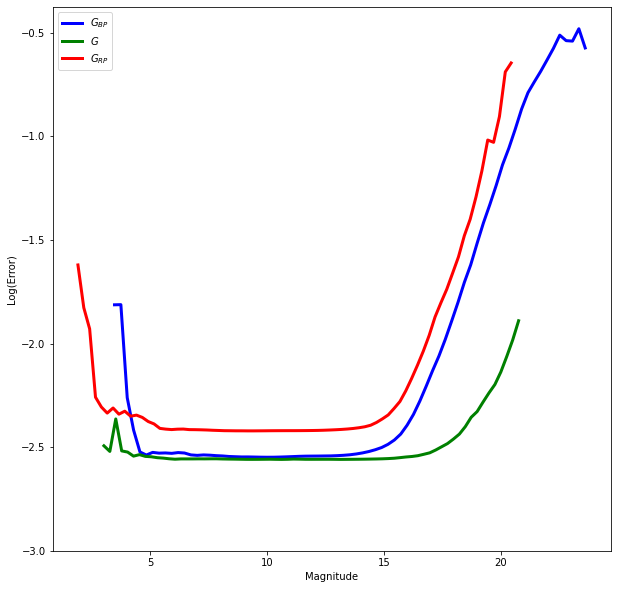

In [11]:
from scipy.stats import binned_statistic, binned_statistic_2d

binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### G
g_fin = np.where(np.isfinite(gaiaedr3['phot_g_mean_mag'])==True)

gmin = min(gaiaedr3['phot_g_mean_mag'][g_fin])
gmax = max(gaiaedr3['phot_g_mean_mag'][g_fin])

gdiff = gmax-gmin
gfluxerr = (2.5*0.434)/gaiaedr3['phot_g_mean_flux_over_error'][g_fin]
gmagerr = np.sqrt((gfluxerr)**2+0.0027553202**2)

gbin ,_,_ = binned_statistic(gaiaedr3['phot_g_mean_mag'][g_fin],np.log10(gmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(gmin,gmax,gdiff/binnum),gbin,lw=3.0,c='green',label=r'$G$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)')
plt.savefig('../plots/gaiaerrorcurve.pdf',dpi=300,bbox_inches='tight');

bperrfunc = bspline(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
gerrfunc = bspline(np.arange(gmin,gmax,gdiff/binnum),gbin)
rperrfunc = bspline(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

### Replace nan's with zeropoint error
bperr = np.nan_to_num(10**bperrfunc(kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']),nan=0.0027901700)
gerr = np.nan_to_num(10**gerrfunc(kdr17['GAIAEDR3_PHOT_G_MEAN_MAG']),nan=0.0027553202)
rperr = np.nan_to_num(10**rperrfunc(kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']),nan=0.0037793818)

# Calculation

In [24]:
kasc_ext = 999999.0*np.ones((500,6))
kasc_ext_err = 999999.0*np.ones((500,6))
kasc_age = 999999.0*np.ones(500)
kasc_chi = 999999.0*np.ones(500)
kasc_rms = 999999.0*np.ones(500)
kasc_mass = 999999.0*np.ones(500)

kasc_age_iter = 999999.0*np.ones(500)
kasc_mass_iter = 999999.0*np.ones(500)
kasc_age_iter_2 = 999999.0*np.ones(500)
kasc_mass_iter_2 = 999999.0*np.ones(500)

kasc_age_iter_test = 999999.0*np.ones(500)
kasc_mass_iter_test = 999999.0*np.ones(500)

for i in tqdm(range(500)):
    
    # Initialize Aetas 
    te = np.array([kdr17['TEFF'][i],kdr17['TEFF_ERR'][i]])
    
    ab = np.array([[kdr17['FE_H'][i],apoafe[i]],
                   [kdr17['FE_H_ERR'][i],apoafe_err[i]]]).T
    
    op = np.array([[kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                    kdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][i],
                    kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                    kdr17['J'][i],kdr17['H'][i],kdr17['K'][i]],
                   [bperr[i],gerr[i],rperr[i],kdr17['J_ERR'][i],
                    kdr17['H_ERR'][i],kdr17['K_ERR'][i]]]).T
    
    di = (1/kdr17['GAIAEDR3_PARALLAX'][i])*1000

    CalcAge = Astrologium(te,ab,op,di,massive)
    
    exts = CalcAge.extinction()
    kasc_ext[i,:],kasc_ext_err[i,:] = exts[:,0],exts[:,1]
    kasc_age[i],kasc_chi[i],kasc_rms[i] = CalcAge.get_age()
    kasc_mass[i] = CalcAge.age_2_mass(kasc_age[i])

  0%|          | 0/500 [00:00<?, ?it/s]

<ipython-input-2-9f4d4090d3b1>:545: RuntimeWarning: divide by zero encountered in log10
  lgage = np.log10(age*10**9)


large
large
large
large
large
large
large
large
large


<ipython-input-2-9f4d4090d3b1>:545: RuntimeWarning: invalid value encountered in log10
  lgage = np.log10(age*10**9)
<ipython-input-2-9f4d4090d3b1>:700: RuntimeWarning: divide by zero encountered in log10
  mass = bspl(np.log10(age*10**9))


small
large
large
large
large
large
small
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
small
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
large
larg

6099

In [26]:
# import pdb

parsec_age = 999999.0*np.ones(500)

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data: data to search through 
        value: value of interest

    Output:
    ------
        close1: closest value under the given value
        close2: closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def mass_2_age_PARSEC(mass,salfeh,teff,isochrones):
    '''
    Inputs:
    ------
        mass: star mass in Msun
        teff: teff
        salfeh: Salaris corrected [Fe/H]
        isochrones: table of PARSEC isochrones
    
    Output:
    ------
        age: age in Gyr
    '''
    
    feh_lo,feh_hi = neighbors(isochrones['MH'],salfeh)
    
    test = np.where((isochrones['logTe']<np.log10(teff+200.))&
                                 (isochrones['logTe']>np.log10(teff-200.)))
    
#     pdb.set_trace()
    
    idx_lo = np.where((isochrones['MH']==feh_lo)&
                                 (isochrones['logTe']<np.log10(teff+200.))&
                                 (isochrones['logTe']>np.log10(teff-200.)))
    
    iso_lo = isochrones[idx_lo]
    
    idx_hi = np.where((isochrones['MH']==feh_hi)&
                                 (isochrones['logTe']<np.log10(teff+200.))&
                                 (isochrones['logTe']>np.log10(teff-200.)))
    
    iso_hi = isochrones[idx_hi]
    
    try:
        # lower [Fe/H]
        sidx_lo = np.argsort(iso_lo['Mass'])
        smass_lo = iso_lo['Mass'][sidx_lo]
        _,uidx_lo = np.unique(smass_lo,return_index=True)
        smass_lo = smass_lo[uidx_lo]
        sage_lo = 10**iso_lo['logAge'][sidx_lo][uidx_lo]/10**9

        spl_lo = interp1d(smass_lo,sage_lo)

        # higher [Fe/H]
        sidx_hi = np.argsort(iso_hi['Mass'])
        smass_hi = iso_hi['Mass'][sidx_hi]
        _,uidx_hi = np.unique(smass_hi,return_index=True)
        smass_hi = smass_hi[uidx_hi]
        sage_hi = 10**iso_hi['logAge'][sidx_hi][uidx_hi]/10**9

        spl_hi = interp1d(smass_hi,sage_hi)

        # final spline
        final_spl = interp1d([feh_lo,feh_hi],[spl_lo(mass),spl_hi(mass)])
        age = final_spl(salfeh)
        return age
    except:
        return 999999.0

for i in tqdm(range(500)):
#     print(kdr17['TEFF'][i])
    parsec_age[i] = mass_2_age_PARSEC(k674['APOKASC3P_MASS'][i],salfeh[i],kdr17['TEFF'][i],massive)

  0%|          | 0/500 [00:00<?, ?it/s]

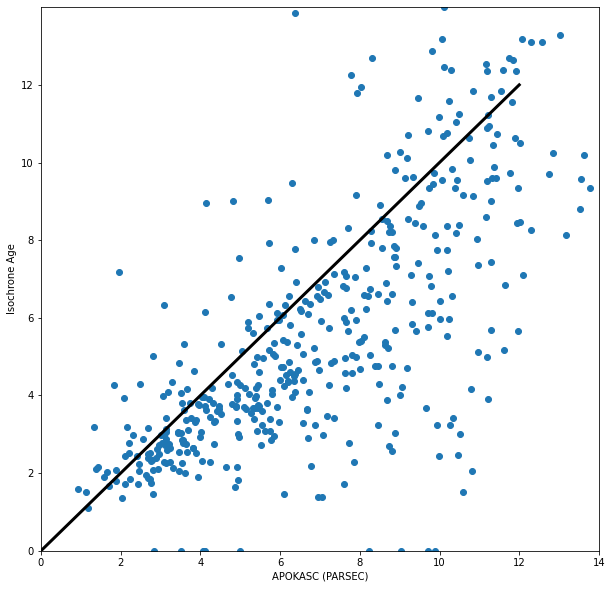

In [27]:
plt.figure(figsize=[10,10])
plt.scatter(parsec_age,kasc_age)
plt.plot([0,12],[0,12],c='k',lw=3.0)
plt.xticks(np.arange(15)[::2])
plt.yticks(np.arange(13)[::2])

plt.xlim(0,14)
plt.ylim(0,14)

plt.xlabel(r'APOKASC (PARSEC)')
plt.ylabel(r'Isochrone Age')
plt.show()

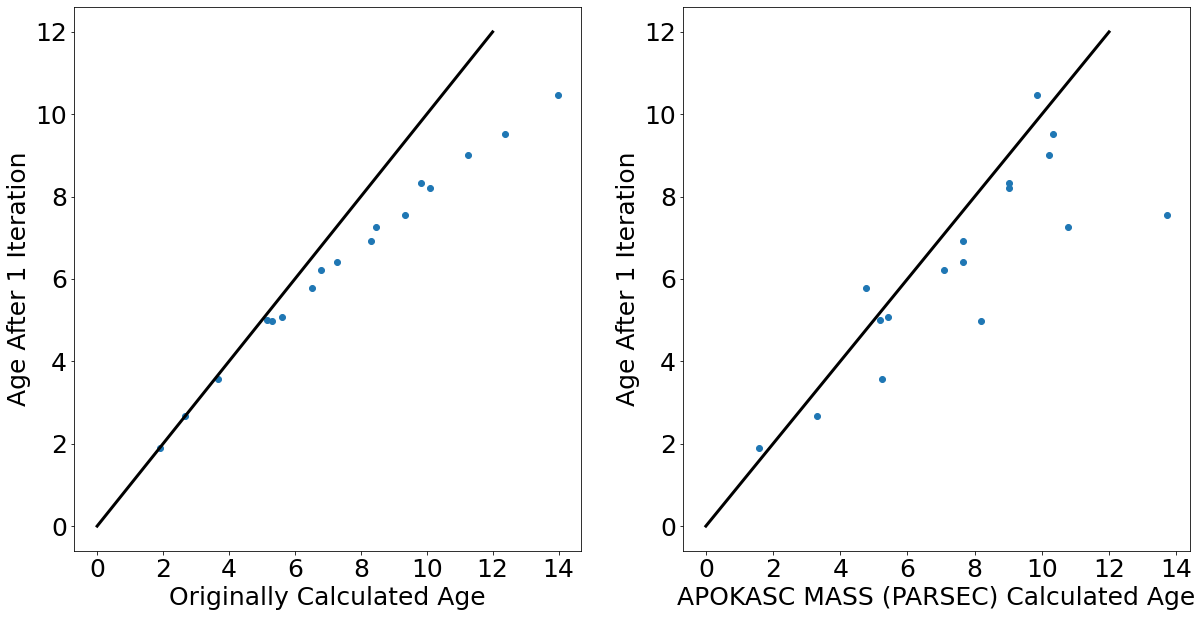

In [182]:
plt.figure(figsize=[20,10])
plt.subplot(121)
plt.scatter(kasc_age,kasc_age_iter)
plt.plot([0,12],[0,12],c='k',lw=3.0)
plt.xticks(np.arange(15)[::2])
plt.yticks(np.arange(13)[::2])
plt.xlabel(r'Originally Calculated Age')
plt.ylabel(r'Age After 1 Iteration')

plt.subplot(122)
plt.scatter(parsec_age,kasc_age_iter)
plt.plot([0,12],[0,12],c='k',lw=3.0)
plt.xticks(np.arange(15)[::2])
plt.yticks(np.arange(13)[::2])
plt.xlabel(r'APOKASC MASS (PARSEC) Calculated Age')
plt.ylabel(r'Age After 1 Iteration')
plt.show()

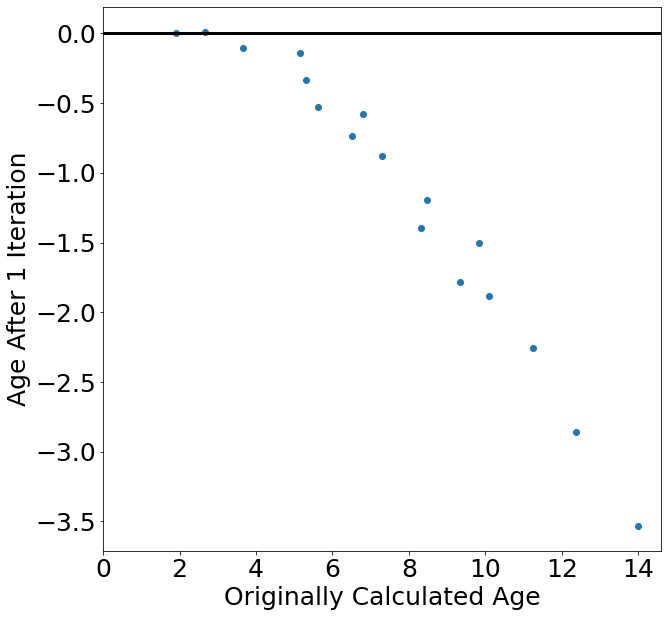

In [183]:
plt.figure(figsize=[10,10])
plt.scatter(kasc_age,kasc_age_iter-kasc_age)
plt.axhline(0.0,c='k',lw=3.0)
# plt.plot([0,12],[0,12],c='k',lw=3.0)
plt.xticks(np.arange(15)[::2])
# plt.yticks(np.arange(13)[::2])
plt.xlabel(r'Originally Calculated Age')
plt.ylabel(r'Age After 1 Iteration')
plt.show()

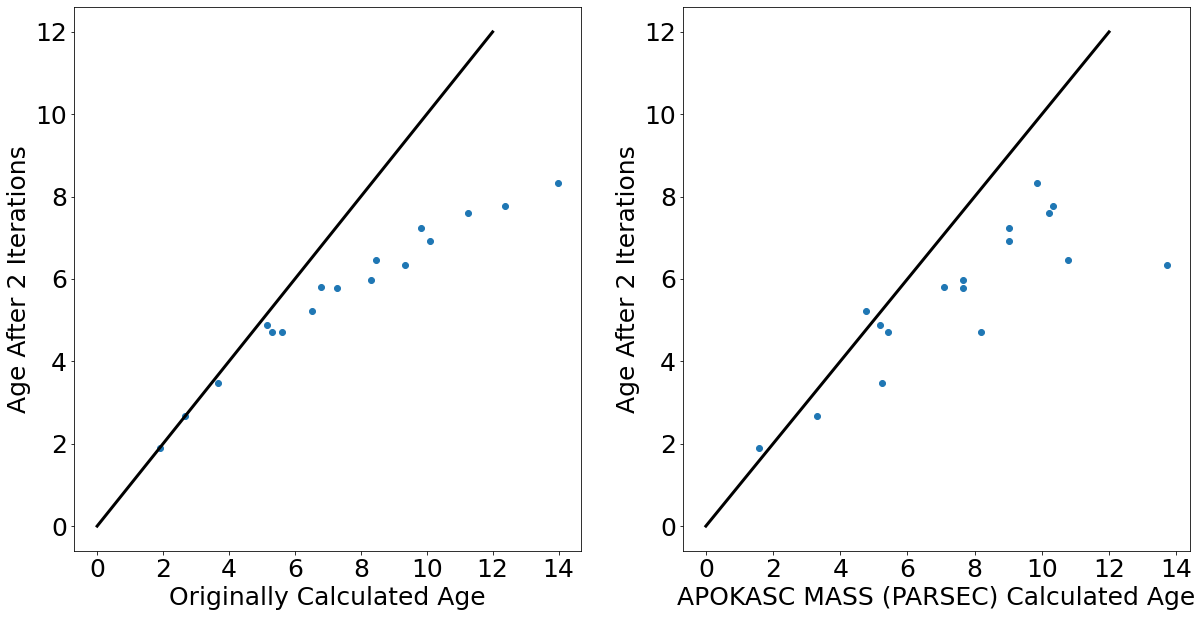

In [184]:
plt.figure(figsize=[20,10])
plt.subplot(121)
plt.scatter(kasc_age,kasc_age_iter_2)
plt.plot([0,12],[0,12],c='k',lw=3.0)
plt.xticks(np.arange(15)[::2])
plt.yticks(np.arange(13)[::2])
plt.xlabel(r'Originally Calculated Age')
plt.ylabel(r'Age After 2 Iterations')

plt.subplot(122)
plt.scatter(parsec_age,kasc_age_iter_2)
plt.plot([0,12],[0,12],c='k',lw=3.0)
plt.xticks(np.arange(15)[::2])
plt.yticks(np.arange(13)[::2])
plt.xlabel(r'APOKASC MASS (PARSEC) Calculated Age')
plt.ylabel(r'Age After 2 Iterations')
plt.show()

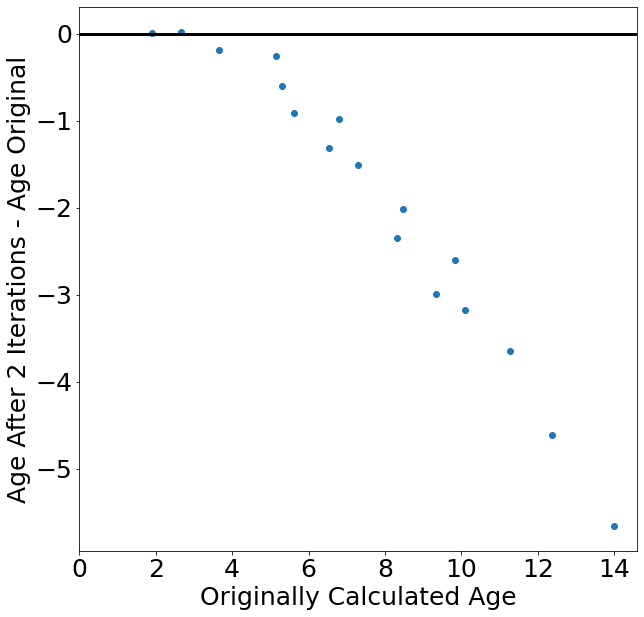

In [187]:
plt.figure(figsize=[10,10])
plt.scatter(kasc_age,kasc_age_iter_2-kasc_age)
plt.axhline(0.0,c='k',lw=3.0)
# plt.plot([0,12],[0,12],c='k',lw=3.0)
plt.xticks(np.arange(15)[::2])
# plt.yticks(np.arange(13)[::2])
plt.xlabel(r'Originally Calculated Age')
plt.ylabel(r'Age After 2 Iterations - Age Original')
plt.show()

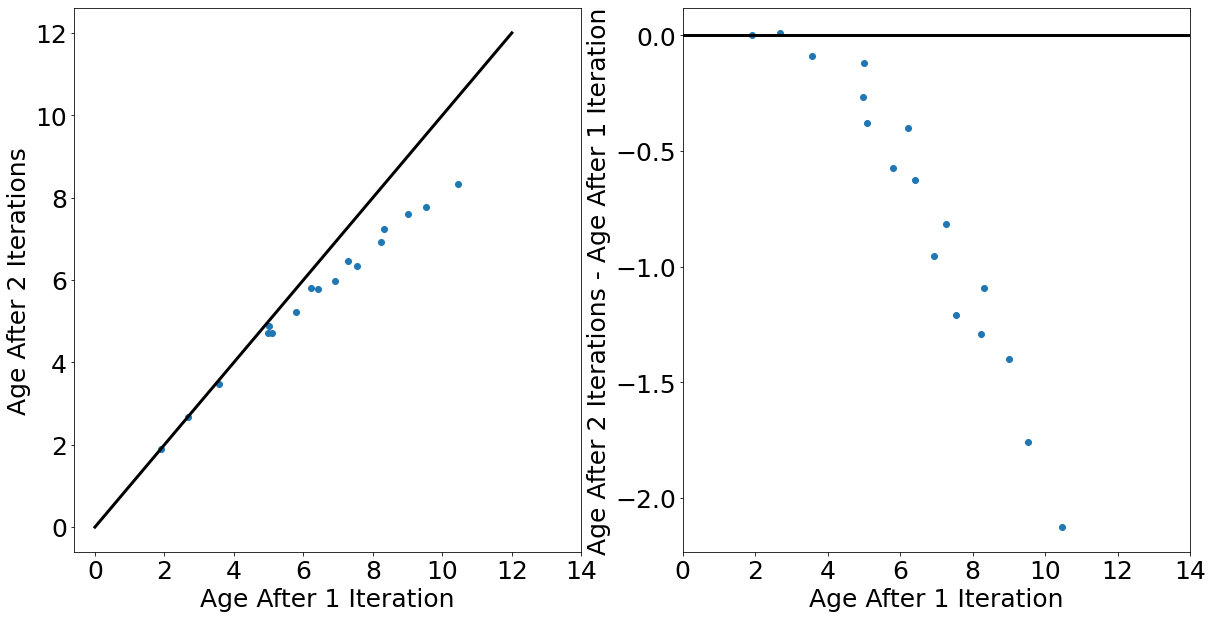

In [191]:
plt.figure(figsize=[20,10])
plt.subplot(121)
plt.scatter(kasc_age_iter,kasc_age_iter_2)
plt.plot([0,12],[0,12],c='k',lw=3.0)
plt.xticks(np.arange(15)[::2])
plt.yticks(np.arange(13)[::2])
plt.xlabel(r'Age After 1 Iteration')
plt.ylabel(r'Age After 2 Iterations')

plt.subplot(122)
plt.scatter(kasc_age_iter,kasc_age_iter_2-kasc_age_iter)
plt.axhline(0.0,c='k',lw=3.0)
plt.xticks(np.arange(15)[::2])
plt.xlabel(r'Age After 1 Iteration')
plt.ylabel(r'Age After 2 Iterations - Age After 1 Iteration')
plt.show()

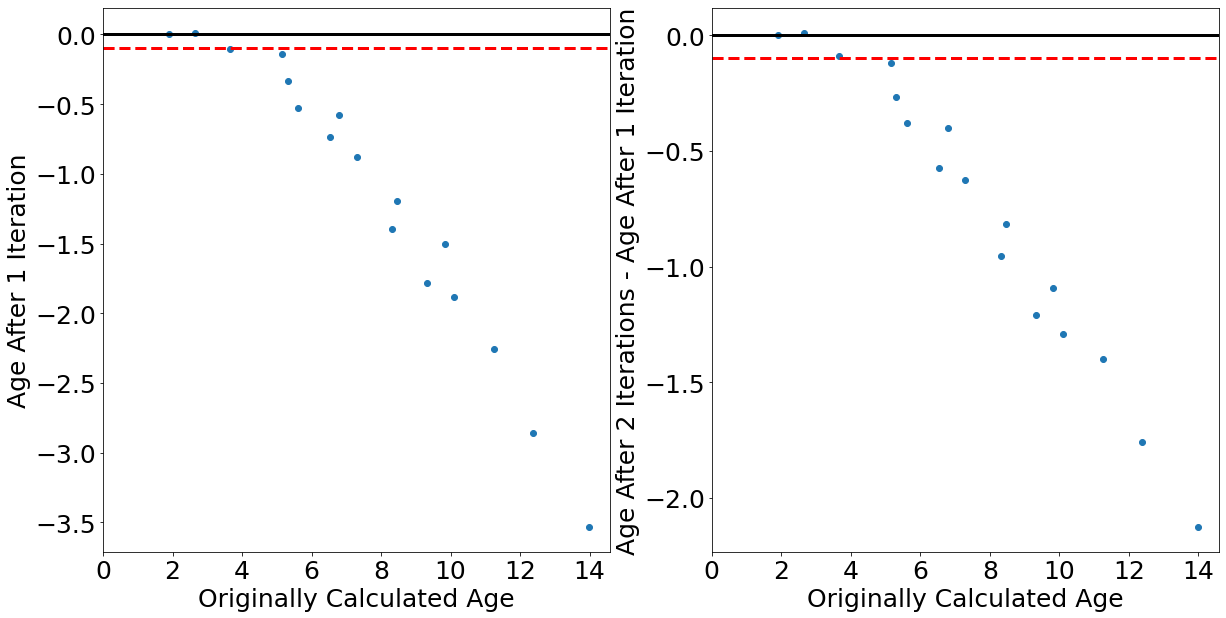

In [195]:
plt.figure(figsize=[20,10])
plt.subplot(121)
plt.scatter(kasc_age,kasc_age_iter-kasc_age)
plt.axhline(0.0,c='k',lw=3.0)
plt.axhline(-0.1,c='r',lw=3.0,ls='--')
# plt.plot([0,12],[0,12],c='k',lw=3.0)
plt.xticks(np.arange(15)[::2])
# plt.yticks(np.arange(13)[::2])
plt.xlabel(r'Originally Calculated Age')
plt.ylabel(r'Age After 1 Iteration')

plt.subplot(122)
plt.scatter(kasc_age,kasc_age_iter_2-kasc_age_iter)
plt.axhline(0.0,c='k',lw=3.0)
plt.axhline(-0.1,c='r',lw=3.0,ls='--')
plt.xticks(np.arange(15)[::2])
plt.xlabel(r'Originally Calculated Age')
plt.ylabel(r'Age After 2 Iterations - Age After 1 Iteration')
plt.show()

0.18192153682390474

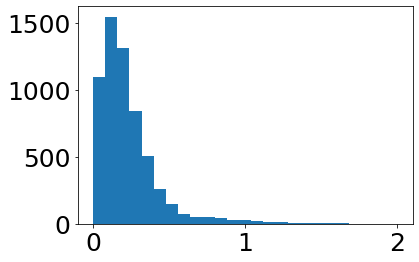

In [122]:
plt.hist(kasc_ext[:,1],range=(0,2),bins=25)
np.nanmedian(kasc_ext[:,1])

3.3695632261600728

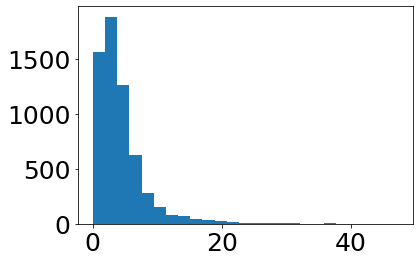

In [126]:
plt.hist(kasc_ext[:,1]/kasc_ext_err[:,1],bins=25)
np.nanmedian(kasc_ext[:,1]/kasc_ext_err[:,1])

In [137]:
np.nanmedian(kasc_ext_err[:,0])

0.06326821700398756

In [113]:
kasc_ext

array([[1.01734343e-02, 8.35107623e-03, 6.43082685e-03, 2.86115910e-03,
        1.81235213e-03, 1.14896887e-03],
       [1.59050361e-01, 1.30559813e-01, 1.00538844e-01, 4.47310488e-02,
        2.83341152e-02, 1.79628537e-02],
       [1.08743474e-01, 8.92643538e-02, 6.87388772e-02, 3.05828268e-02,
        1.93721668e-02, 1.22812869e-02],
       ...,
       [6.09598929e-01, 5.00402023e-01, 3.85339408e-01, 1.71442550e-01,
        1.08597341e-01, 6.88469761e-02],
       [2.43261728e+00, 1.99686474e+00, 1.53770497e+00, 6.84145081e-01,
        4.33359962e-01, 2.74735298e-01],
       [3.17662463e-01, 2.60759873e-01, 2.00800657e-01, 8.93388425e-02,
        5.65901567e-02, 3.58762114e-02]])